In [7]:
import numpy as np
import pandas as pd
from gnews import GNews
import yfinance as yf
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt

In [38]:
def extract_economic_news(language='fr', max_results=50, period='7d', topic='ECONOMY'):
    google_news = GNews(language=language, max_results=max_results, period=period)
    news = google_news.get_news_by_topic(topic)
    title_news = [article['title'] for article in news]
    return news,title_news

def align_with_index(df1, df2, date_col='Date', join_type='inner'):
    """
    Align datasets using pandas align method.
    join_type: 'inner', 'outer', 'left', 'right'
    """
    # Set date as index
    df1_indexed = df1.set_index(pd.to_datetime(df1[date_col], format='%d/%m/%Y'))
    df2_indexed = df2.set_index(pd.to_datetime(df2[date_col], format='%d/%m/%Y'))
    
    # Align the dataframes
    df1_aligned, df2_aligned = df1_indexed.align(df2_indexed, join=join_type, axis=0)
    
    return df1_aligned, df2_aligned


In [39]:
df_oat = pd.read_csv("Rendement de l'Obligation France 10 ans - Données Historiques (1).csv")
df_bund = pd.read_csv("Rendement de l'Obligation Allemagne 10 ans - Données Historiques.csv")
df_oat_aligned, df_bund_aligned = align_with_index(df_oat, df_bund, date_col='Date', join_type='inner')
df_oat_aligned['Dernier'] = df_oat_aligned['Dernier'].str.replace(',', '.').astype(float)
df_bund_aligned['Dernier'] = df_bund_aligned['Dernier'].str.replace(',', '.').astype(float)
y = df_oat_aligned['Dernier']/df_bund_aligned['Dernier']
y.sort_index(inplace=True)

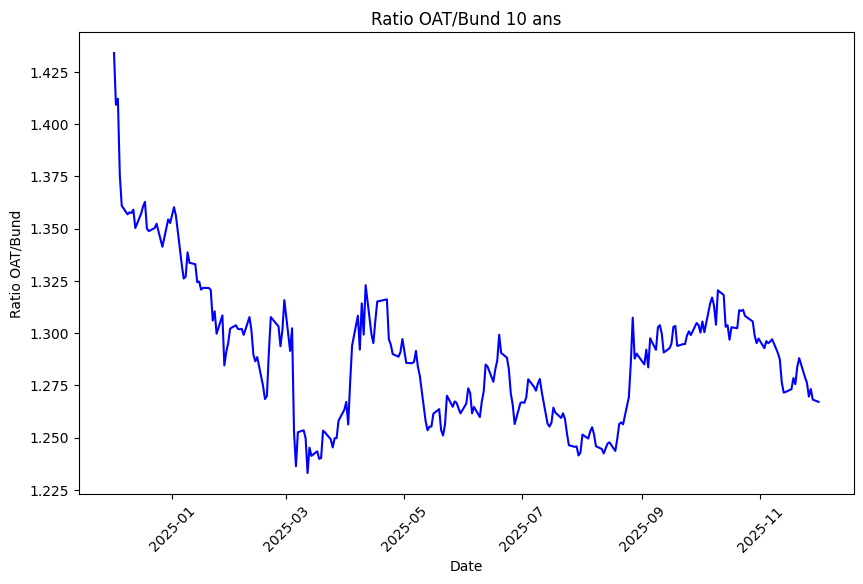

In [ ]:
start_date = '2024-12-01'
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(y[start_date:], label=f'Ratio OAT/Bund depuis {start_date}', color='blue')
ax.set_title("Ratio OAT/Bund 10 ans")
ax.set_xlabel("Date")
ax.set_ylabel("Ratio OAT/Bund")
plt.xticks(rotation=45)
plt.show()

Fitting an ARMA process on the ratio to give the 'basic prediction'.

In [51]:
#import adf test
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(y[start_date:])
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -2.7002401806237977
p-value: 0.07399671652308822


In [82]:
spread_one_year = y[:numbers_of_points]
spread_one_year_diff = spread_one_year.diff().dropna()

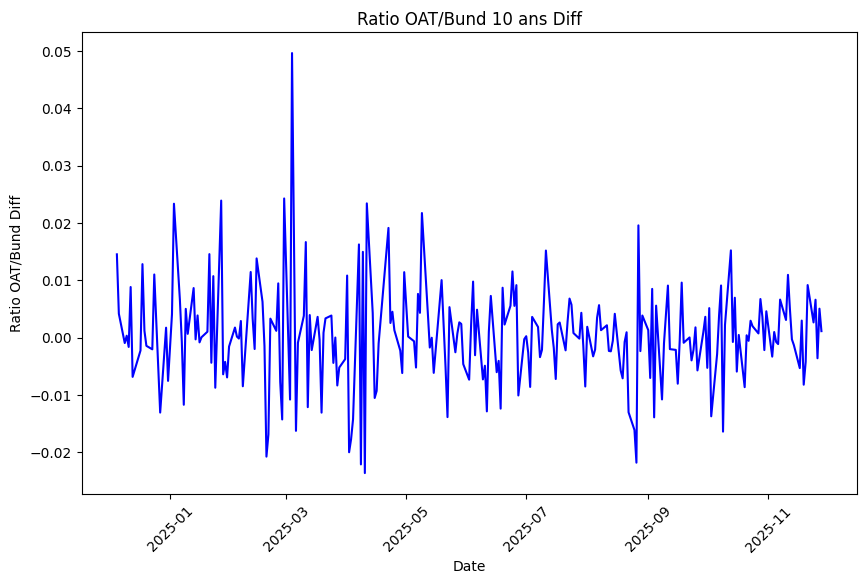

In [83]:
fig, ax = plt.subplots(figsize=(10, 6))
ax.plot(df_oat_aligned['Date'][1:numbers_of_points], spread_one_year_diff, label='Ratio OAT/Bund 10 ans Diff', color='blue')
ax.set_title("Ratio OAT/Bund 10 ans Diff")
ax.set_xlabel("Date")
ax.set_ylabel("Ratio OAT/Bund Diff")
plt.xticks(rotation=45)
plt.show()

In [84]:
from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(spread_one_year_diff)
print('ADF Statistic:', adf_result[0])
print('p-value:', adf_result[1])

ADF Statistic: -6.6580510123087375
p-value: 4.926735330871125e-09


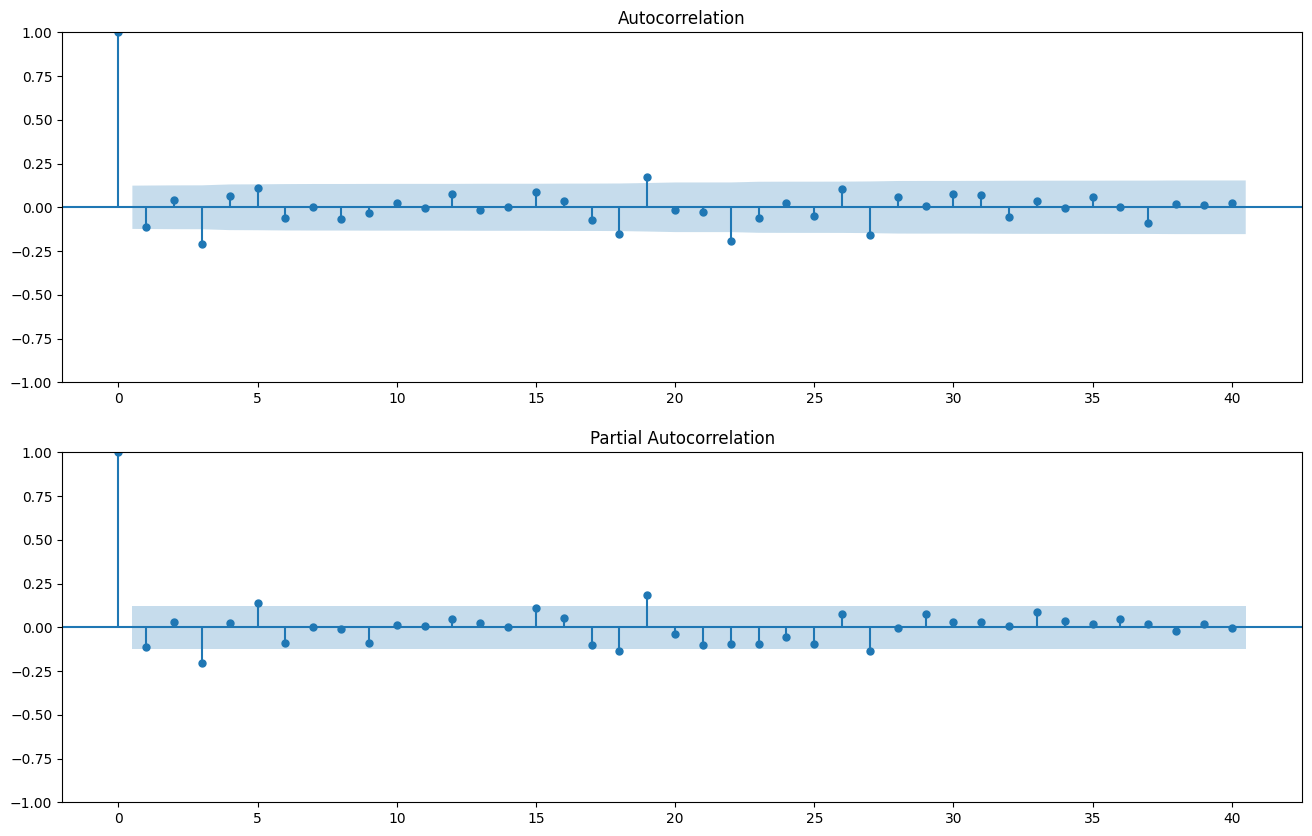

In [85]:
#Plotting pcf and acf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig, ax = plt.subplots(2,1, figsize=(16,10))
plot_acf(spread_one_year_diff, ax=ax[0], lags=40)
plot_pacf(spread_one_year_diff, ax=ax[1], lags=40)
plt.show()

In [86]:
# p = 3, q=3
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(spread_one_year, order=(3,1,3))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                Dernier   No. Observations:                  252
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 839.882
Date:                Tue, 02 Dec 2025   AIC                          -1665.764
Time:                        10:53:40   BIC                          -1641.086
Sample:                             0   HQIC                         -1655.833
                                - 252                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3990      0.254     -1.568      0.117      -0.898       0.100
ar.L2         -0.4415      0.252     -1.751      0.080      -0.936       0.053
ar.L3         -0.1012      0.223     -0.453      0.6

In [52]:
french_economy, french_title = extract_economic_news(max_results=70)
german_economy, german_title = extract_economic_news(language='de')

In [54]:
french_title

["« Récession », « krach boursier » : le scénario noir pour l'économie américaine en cas d'annexion du Groenland - La Tribune",
 'Wall Street pas convaincue par une nouvelle salve de données économiques - Boursorama',
 'Salaires : avec le ralentissement de l’inflation, les grandes entreprises délaissent les augmentations collectives - Le Monde.fr',
 "Où sont placés les 6.600 milliards d'épargne des Français ? - Les Echos",
 'Demande en baisse, forte concurrence internationale... Le verrier Arc enferré dans une restructuration permanente - Le Figaro',
 "Venezuela : derrière le pétrole, le retour à une hégémonie du dollar - L'Humanité",
 "Crise agricole : désabusé depuis les actions de 2024, Benoît n'a pas rejoint la mobilisation cette année - France 3 Régions",
 'Inflation à 42%, monnaie en chute libre… Que se passe-t-il en Iran ? - BFM',
 'Immobilier 2026 : top 3 des villes où la demande explose (les acheteurs ont tranché) - PAP',
 "L'inflation en zone euro revient à 2% en décembre, da

In [24]:
from fredapi import Fred

# Obtenir une clé API gratuite sur: https://fred.stlouisfed.org/docs/api/api-key.html
FRED_API_KEY = 'c1d79a456b2cc144c9132a39f0865cd8'
fred = Fred(api_key=FRED_API_KEY)

# Dictionnaire des séries FRED
series_dict = {
    'FPCPITOTLZGFRA': 'FR_Inflation_CPI',
    'CLVMNACSCAB1GQFR': 'FR_PIB',
    'LRHUTTTTFRM156S': 'FR_Unemployment_Rate',
    'GGGDTAFRA188N': 'FR_Debt_Rate',
    'FPCPITOTLZGDEU': 'DE_Inflation_CPI',
    'CLVMNACSCAB1GQDE': 'DE_PIB_Growth',
    'LRHUTTTTDEM156S': 'DE_Unemployment_Rate',
    'GGGDTADEA188N': 'DE_Debt_Rate',
}

data_frames = []
for series_id, label in series_dict.items():
    try:
        data = fred.get_series(series_id, observation_start='2020-01-01', observation_end='2026-01-08')
        df = pd.DataFrame({label: data})
        if label == 'FR_PIB' or label == 'DE_PIB_Growth':
            df[label] = (np.log(df[label]/df[label].shift()) * 400).round(2)
        data_frames.append(df)
    except Exception as e:
        print(f"Erreur pour {label}: {e}")

macro_data = pd.concat(data_frames, axis=1)
print(macro_data.head())
# Transformer le PIB en variation trimestrielle


macro_processed = macro_data


            FR_Inflation_CPI  FR_PIB  FR_Unemployment_Rate  FR_Debt_Rate  \
2020-01-01          0.476499     NaN                   8.2       114.831   
2020-02-01               NaN     NaN                   7.8           NaN   
2020-03-01               NaN     NaN                   7.6           NaN   
2020-04-01               NaN  -52.13                   7.6           NaN   
2020-05-01               NaN     NaN                   6.9           NaN   

            DE_Inflation_CPI  DE_PIB_Growth  DE_Unemployment_Rate  \
2020-01-01          0.144878            NaN                   3.2   
2020-02-01               NaN            NaN                   3.3   
2020-03-01               NaN            NaN                   3.4   
2020-04-01               NaN         -37.17                   3.5   
2020-05-01               NaN            NaN                   3.7   

            DE_Debt_Rate  
2020-01-01        68.035  
2020-02-01           NaN  
2020-03-01           NaN  
2020-04-01          

In [26]:
macro_processed.to_csv('macro_processed.csv')